In [3]:
import warnings
warnings.simplefilter('ignore')

from sklearn.externals import joblib
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

import re
import pickle
import numpy as np
import pandas as pd
import csv

from stop_words import get_stop_words
import string

from nltk.tokenize.casual import TweetTokenizer

from gensim import matutils, corpora, models
import gensim

import eli5

# Set Notebook parameters
Here we set variables necessary for pre-processing.

In [5]:
def tokenize_func(doc, tknzr=TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)):

    # remove URLs
    doc = re.sub(r'^(https|http)?:\/\/.*(\r|\n|\b)', '', doc, flags=re.MULTILINE)
    
    # tokenize
    tokens = tknzr.tokenize(doc)

    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    nopunct_tokens = [w.translate(table) for w in tokens]
    for tok in nopunct_tokens:
        if 'httptco' in tok:
            ind = nopunct_tokens.index(tok)
            del(nopunct_tokens[ind])
        elif 'httpstco' in tok:
            ind = nopunct_tokens.index(tok)
            del(nopunct_tokens[ind])

    # keep words length 3 or more
    long_tokens = [token for token in nopunct_tokens if len(token) > 2]

    # remove remaining tokens that are not alphabetic
    alpha_tokens = [word for word in long_tokens if word.isalpha()]

    # remove stop words from tokens
    stopped_tokens = [i for i in alpha_tokens if not i in stop_words_2]
        
    return stopped_tokens

def replace_urls(text):
    text_clean = re.sub(r'^(https|http)?:\/\/.*(\r|\n|\b)', '', text, flags=re.MULTILINE)
    return text_clean

In [6]:
stop_words_en = get_stop_words('en') # English stoplist
stop_words_sp = get_stop_words('spanish') # Spanish stoplist

stop_words_2 = []

for word in stop_words_en:
    stop_words_2.append(word)
for word in stop_words_sp:
    stop_words_2.append(word)

# Label Data

### Load Data

In [7]:
## note that given licensing limitations, we have not shared raw data in this public repo. as such,
## the data file that we list here is the processed dataset, with all columns included
data_file = '../../../data/congress_115/congress115.csv.gz'
tweets = pd.read_csv(data_file, compression='gzip', dtype=str) 

## Unsupervised Labels

### Add Unsupervised Model Labels to Data

In [8]:
# get in data that has unsupervised model labels on it
unsup_data = '../../../data/unsupervised/model_output/congress115_compostion_50.txt.gz'
unsup = pd.read_csv(unsup_data, compression='gzip', sep='\t')

In [9]:
def process_unsup_labels(unsup):
    
    unsup = unsup.drop(['0'], axis=1)
     
    ## rename topic columns to topic numbers
    counter = 0
    for each in list(unsup.columns.values)[1:]:
        unsup.rename(columns = {str(each): str(counter)}, inplace = True)
        counter += 1
    unsup.head()
    
    ## make the first column, which currently contains all three of id_str user_id and preprocessed_text, 
    ## three columns and assign appropriate column names
    newdf = unsup['id_str,user_id,preprocessed_text'].apply(lambda x: pd.Series(x.split(',')))
    newdf.rename(columns={0:'id_str',1:'user_id',2:'preprocessed_text'},inplace=True)
    newdf = newdf.drop([3], axis=1)
    
    ## now add back all of the topic columns
    new_unsup = pd.concat([newdf, unsup], axis=1)
    new_unsup = new_unsup.drop(['id_str,user_id,preprocessed_text'], axis=1)
    
    return new_unsup

In [10]:
new_unsup = process_unsup_labels(unsup)

### Find Unsupervised Maximum Probability Topics for Each Tweet

In [8]:
## we'll need to load the file of topics with terms, and manually added human interpretations of
## what those topics are, and then manual policy code numeric assignment associated with those.
## for those topics that weren't in the policy codebook, we created new numbers. this set of keys will 
## help us match up policy codebook numbers with our dataframe's topic numbers. 

labels_file = '../../../data/unsupervised/model_output/congress115_keys_50.txt'
labels = pd.read_csv(labels_file, sep='\t')

In [9]:
def find_max_probability_topics(new_unsup):
    
    props = new_unsup.loc[:, '0':'49']
    maxdf = props.idxmax(axis=1)
    new_unsup['max_topic'] = maxdf
    ranks = props.rank(axis=1,method='dense', ascending=False).astype(int)
    new_unsup['max_topic_2'] = ranks.where(ranks==2).notnull().values.nonzero()[1]   
    final_unsup = new_unsup[['id_str', 'user_id', 'max_topic', 'max_topic_2']]
    
    return final_unsup

def rename_labels_to_policy(labels, df):
    
    ## rename final_unsup topic codes to be policy code book codes
    topnames = list(map(int, df.max_topic.unique())) # these are the unique topic numbers in 'max_topic'
    for ind,item in labels.iterrows():
        lda_label = item['topic_code'] # this is the topic number
        if lda_label in topnames:
            policycode = list(labels.loc[labels['topic_code'] == lda_label, ['policy_codebook_code']]['policy_codebook_code'])[0]
            df.loc[df['max_topic'] == str(int(lda_label)),['max_topic']] = policycode

    ## recast policy codes as floats
    topnames2 = list(map(int,df.max_topic_2.unique())) # these are the unique topic numbers in 'max_topic_2'
    # labels['topic_code'] = labels.topic_code.astype('float') # use if needed
    for ind,item in labels.iterrows():
        lda_label = item['topic_code']
        if lda_label in topnames2:
            policycode = list(labels.loc[labels['topic_code'] == lda_label, ['policy_codebook_code']]['policy_codebook_code'])[0]
            df.loc[df['max_topic_2'] == str(int(lda_label)),['max_topic_2']] = policycode
    
    return df

def merge_labels(df, df_t):
    
    ## merge on id_str to get our tweet text for the supervised model labeling
    tweets_unsup_labeled = pd.merge(df, df_t, left_on = 'id_str', right_on = 'id_str', how = 'left')
    tweets_unsup_labeled.rename(columns = {'user_id_x': 'user_id'}, inplace = True)
    tweets_unsup_labeled = tweets_unsup_labeled.drop(['user_id_y'], axis=1)
    
    ## in case there are any nans in full_text
    tweets_unsup_labeled = tweets_unsup_labeled.dropna(subset=['full_text'])
    
    return tweets_unsup_labeled

In [10]:
final_unsup = find_max_probability_topics(new_unsup)

In [11]:
policy_unsup = rename_labels_to_policy(labels, final_unsup)

In [101]:
tweets_unsup_labeled = merge_labels(policy_unsup, tweets)

Since our data is already labeled with unsupervised and supervised model policy labels, if you've run the labeling code above, you'll now have four topic label columns instead of two. Your two newly labeled columns will be:

    'max_topic_x'
    'max_topic_2_x'

Our original topic labels will be columns:

    'max_topic_y'
    'max_topic_2_y'
   
To work with either set of columns, uncomment the approriate lines below to drop and rename columns for input into the code that follows.

In [106]:
## to work with original labels
tweets_unsup_labeled = tweets_unsup_labeled.drop(['max_topic_x', 'max_topic_2_x'], axis=1)
tweets_unsup_labeled = tweets_unsup_labeled.rename(columns={'max_topic_y': 'max_topic',
                                                            'max_topic_2_y': 'max_topic_2'})

## to work with your new labels
# tweets_unsup_labeled = tweets_unsup_labeled.drop(['max_topic_y', 'max_topic_2_y', axis=1])
# tweets_unsup_labeled = tweets_unsup_labeled.rename(columns={'max_topic_x': 'max_topic',
#                                                             'max_topic_2_x': 'max_topic_2'})

In [13]:
## output to csv if desired
# tweets_unsup_labeled.to_csv('../../../data/congress_115/INSERT_FILE_NAME.csv.gz', index=False,
#                            compression='gzip')

## Supervised Labels

### Label Data with Supervised Model Predictions 

In [11]:
## load best bodel, logisitc regression with no w2v or liwc features, and preserving 90% not-policy tweets
with open('../../../models/best/lr/lr_0.9.pkl', 'rb') as file:  
    lr_loaded = joblib.load(file)

In [36]:
def predict_sup_labels(df, model):
    
    df['policy_area_lr'] = model.predict(df.text_tokenized)
    
    return df

In [ ]:
## run this cell to generate new predictions
tweets_complete_labeled = predict_sup_labels(tweets_unsup_labeled, lr_loaded)

In [16]:
## output to csv if desired
# tweets_complete_labeled.to_csv('../../../data/congress_115/INSERT_FILE_NAME.csv.gz', 
#                             index=False, compression='gzip')

### Get Feature Weights for Supervised Model

In [64]:
def get_top20_features(model):
    
    ## get feature weights
    weights_df = eli5.explain_weights_df(model, top=20)
    weights_t = weights_df.T
    
    ## reformat weights df
    policies = ['0','1','10','12','13','14','15','16','17','18','19','2','20','21','3','4','5','6','7','8','9']
    for n in policies:
        cols = list(weights_t)
        weights_t[n] = weights_t[cols[:20]].apply(lambda x: ','.join(x.fillna('').map(str)), axis=1)
        weights_t = weights_t.drop(cols[:20], axis=1)
    pd.set_option('display.max_colwidth', 50)
    weight_t2 = weights_t.copy()
    weight_t2 = weight_t2.drop(['target', 'weight'])
    weight_col = weight_t2.T
    weight_col.reset_index(level=0, inplace=True)
    weight_col = weight_col.rename(columns = {'index': 'policy_code', 'feature': 'topic_associated_terms'})
    weight_col = weight_col.sort_values(by=['policy_code'])
    weight_col['policy_code'] = weight_col['policy_code'].astype(int)
    weight_col.set_index(['policy_code'],inplace=True)
    weight_col = weight_col.sort_index()
    
    return weight_col

In [65]:
weights_df = get_top20_features(lr_loaded)

In [19]:
## uncomment to write weights_df to latex file
# with open('../../../reports/tables/su_features.tex', 'w') as tf:
#      tf.write(weights_df.to_latex())

# Investigate Topic Distribution for Supervised and Unsupervised Labels

## Generate Tables and Charts Representing Topic Distributions

### Define General Topic Distribution Functions

In [66]:
def generate_dist_dfs(df):
    
    ## first make df with only policy tweets
    df['policy_area_lr'] = df['policy_area_lr'].apply(pd.to_numeric)
    df['policy_tweet'] = np.where(df['policy_area_lr'] > 0, 1, 0)
    df["policy_tweet"] = df["policy_tweet"].apply(pd.to_numeric)
    policy_tweets = df.loc[df['policy_tweet'] == 1]
    policy_tweets["max_topic"] = policy_tweets["max_topic"].apply(pd.to_numeric)
    policy_code_tweets = policy_tweets.loc[policy_tweets['max_topic'] <= 23]
    
    ## by party if desired
    rep_df = policy_tweets.loc[df['party'] == 'Republican']
    dem_df = policy_tweets.loc[df['party'] == 'Democrat']

    return policy_tweets, policy_code_tweets, rep_df, dem_df
    

def generate_topicdist_table(df, fname):
    
    sup_d = dict(df.policy_area_lr.value_counts())
    sup_df = pd.DataFrame.from_dict(sup_d, orient='index')
    sup_df.columns = ['freq_sup']
    sup_df.reset_index(level=0, inplace=True)
    sup_df['index'] = sup_df['index'].astype(str)
    sup_freqs = list(sup_df['freq_sup'])
    sup_df['SU'] = sup_df['freq_sup']/sum(sup_freqs)
    
    ## get a list of the unique policy areas and their counts in unsupervised labels col
    unsup_d = dict(df.max_topic.value_counts())
    unsup_df = pd.DataFrame.from_dict(unsup_d, orient='index')
    unsup_df.columns = ['freq_unsup']
    unsup_df.reset_index(level=0, inplace=True)
    unsup_df['index'] = unsup_df['index'].astype(str)
    unsup_df.columns.names = ['code']
    unsup_freqs = sorted(list(unsup_df['freq_unsup']))
    unsup_df['UN1'] = unsup_df['freq_unsup']/sum(unsup_freqs)
    
    unsup_d2 = dict(df.max_topic_2.value_counts())
    unsup_df2 = pd.DataFrame.from_dict(unsup_d2, orient='index')
    unsup_df2.columns = ['freq_unsup_2']
    unsup_df2.reset_index(level=0, inplace=True)
    unsup_df2['index'] = unsup_df2['index'].astype(str)
    unsup_df2.columns.names = ['code']
    unsup_freqs2 = sorted(list(unsup_df2['freq_unsup_2']))
    unsup_df2['UN2'] = unsup_df2['freq_unsup_2']/sum(unsup_freqs2)

    ## merge on index to get a composite table 
    merge_df = pd.merge(sup_df, unsup_df, how='outer', on='index')
    merged_df = pd.merge(merge_df, unsup_df2, how='outer', on='index')
    merged_df = merged_df.sort_values(by=['index'])
    merged_df = merged_df.rename(columns = {'index': 'policy_code'})
    merged_df['policy_code'] = merged_df['policy_code'].astype(int)
    merged_df.set_index(['policy_code'],inplace=True)
    merged_df = merged_df.sort_index()
    merged_df = merged_df.drop(['freq_sup', 'freq_unsup', 'freq_unsup_2'], axis=1)
    print(merged_df)
    # with open(fname, 'w') as tf:
    #     tf.write(merged_df.to_latex())

    return merged_df


def generate_topicdist_chart(df):
    
    ## prepare to make merged_df into a chart
    df2 = df.iloc[:21]
    df2 = df2.drop([0])
    df2 = df2.reset_index().sort_values('policy_code', ascending=False)
    df2 = df2.rename(columns = {'policy_code': 'Code Number'}) 

    ## make a chart
    df2.plot(x='Code Number', y=["UN1", "SU"], kind="barh", 
                                 figsize=(5,15), width=.7, color=['darkseagreen','gold'], edgecolor='black',
                                 linewidth=0.6)
    ## uncomment to save figure
    # plt.savefig('../../../reports/figures/topicdistplot_sup_unsup_max12.png')
    plt.show()

### Define Topic Distribution by Party Functions

In [113]:
def generate_party_table(df):
    
    ## republicans
    sup_d = dict(df[df.party == 'Republican'].policy_area_lr.value_counts())
    sup_df = pd.DataFrame.from_dict(sup_d, orient='index')
    sup_df.columns = ['SU_Rep']
    sup_df.reset_index(level=0, inplace=True)
    sup_df['index'] = sup_df['index'].astype(str)

    unsup_d = dict(df[df.party == 'Republican'].max_topic.value_counts())
    unsup_df = pd.DataFrame.from_dict(unsup_d, orient='index')
    unsup_df.columns = ['UN1_Rep']
    unsup_df.reset_index(level=0, inplace=True)
    unsup_df['index'] = unsup_df['index'].astype(str)

    unsup_d2 = dict(df[df.party == 'Republican'].max_topic_2.value_counts())
    unsup_df2 = pd.DataFrame.from_dict(unsup_d2, orient='index')
    unsup_df2.columns = ['UN2_Rep']
    unsup_df2.reset_index(level=0, inplace=True)
    unsup_df2['index'] = unsup_df2['index'].astype(str)
    
    rep_df = pd.merge(sup_df, unsup_df, how='outer', on='index')
    reps_df = pd.merge(rep_df, unsup_df2, how='outer', on='index')

    
    ## democrats
    sup_d = dict(df[df.party == 'Democrat'].policy_area_lr.value_counts())
    sup_df = pd.DataFrame.from_dict(sup_d, orient='index')
    sup_df.columns = ['SU_Dem']
    sup_df.reset_index(level=0, inplace=True)
    sup_df['index'] = sup_df['index'].astype(str)

    unsup_d = dict(df[df.party == 'Democrat'].max_topic.value_counts())
    unsup_df = pd.DataFrame.from_dict(unsup_d, orient='index')
    unsup_df.columns = ['UN1_Dem']
    unsup_df.reset_index(level=0, inplace=True)
    unsup_df['index'] = unsup_df['index'].astype(str)

    unsup_d2 = dict(df[df.party == 'Democrat'].max_topic_2.value_counts())
    unsup_df2 = pd.DataFrame.from_dict(unsup_d2, orient='index')
    unsup_df2.columns = ['UN2_Dem']
    unsup_df2.reset_index(level=0, inplace=True)
    unsup_df2['index'] = unsup_df2['index'].astype(str)
    
    dem_df = pd.merge(sup_df, unsup_df, how='outer', on='index')
    dems_df = pd.merge(dem_df, unsup_df2, how='outer', on='index')

    ## merge
    merged_df = pd.merge(reps_df, dems_df, how='outer', on='index')
    merged_df['Total_SU'] = merged_df[['SU_Rep', 'SU_Dem']].sum(axis=1)
    merged_df['Total_UN1'] = merged_df[['UN1_Rep', 'UN1_Dem']].sum(axis=1)
    merged_df['Total_UN2'] = merged_df[['UN2_Rep', 'UN2_Dem']].sum(axis=1)
    merged_df['SU_Rep'] = merged_df['SU_Rep']/merged_df['Total_SU']
    merged_df['SU_Dem'] = merged_df['SU_Dem']/merged_df['Total_SU']
    merged_df['UN1_Rep'] = merged_df['UN1_Rep']/merged_df['Total_UN1']
    merged_df['UN1_Dem'] = merged_df['UN1_Dem']/merged_df['Total_UN1']
    merged_df['UN2_Rep'] = merged_df['UN2_Rep']/merged_df['Total_UN2']
    merged_df['UN2_Dem'] = merged_df['UN2_Dem']/merged_df['Total_UN2']
    
    merged_df = merged_df.sort_values(by=['index'])
    merged_df = merged_df.rename(columns = {'index': 'policy_code'})
    merged_df['policy_code'] = merged_df['policy_code'].astype(int)
    merged_df.set_index(['policy_code'],inplace=True)
    merged_df = merged_df.sort_index()

    return merged_df


def generate_party_charts(df, sup_file, unsup1_file, unsup2_file):
    
    party_df = generate_party_table(df)
    party_df = party_df.reset_index().sort_values('policy_code', ascending=False)
    party_df = party_df.rename(columns = {'policy_code': 'Code Number'}) 
    
    ## generate supervised labels chart
    su_df = party_df.copy()
    su_df.plot(x='Code Number', y=['SU_Rep', 'SU_Dem'], kind="barh", 
                                 figsize=(5,15), width=.7, color=['coral','cornflowerblue'], edgecolor='black',
                                 linewidth=0.6, stacked=True)
    ## uncomment to save figure
    # plt.savefig(sup_file)
    plt.show()
    
    ## generate unsupervised labels chart for maximum probability topic
    un1_df = party_df.copy()
    un1_df.plot(x='Code Number', y=['UN1_Rep', 'UN1_Dem'], kind="barh", 
                                 figsize=(5,15), width=.7, color=['coral','cornflowerblue'], edgecolor='black',
                                 linewidth=0.6, stacked=True)
    ## uncomment to save figure
    # plt.savefig(unsup1_file)
    plt.show()
    
    ## generate unsupervised labels chart for 2nd highest probability topic
    un2_df = party_df.copy()
    un2_df.plot(x='Code Number', y=['UN2_Rep', 'UN2_Dem'], kind="barh", 
                                 figsize=(5,15), width=.7, color=['coral','cornflowerblue'], edgecolor='black',
                                 linewidth=0.6, stacked=True)
    ## uncomment to save figure
    # plt.savefig(unsup2_file)
    plt.show()

### Run Functions
Uncomment any function runs as needed.

In [108]:
policy_tweets, policy_code_tweets, rep_df, dem_df = generate_dist_dfs(tweets_unsup_labeled)

In [111]:
merged_df = generate_topicdist_table(policy_code_tweets, '../../../reports/tables/topicdist_sup_unsup.tex')

                   SU       UN1       UN2
policy_code                              
0                 NaN  0.025891  0.247785
1            0.116018  0.110061  0.055770
2            0.076193  0.097788  0.044683
3            0.175743  0.396645  0.056206
4            0.018967  0.030891  0.017225
5            0.043064  0.036314  0.022002
6            0.040592  0.032294  0.018353
7            0.036284  0.042536  0.014370
8            0.025097       NaN       NaN
9            0.040094  0.028720  0.014614
10           0.020314       NaN  0.023463
12           0.084445  0.043724  0.020448
13           0.017554  0.035149  0.018568
14           0.005747       NaN       NaN
15           0.043320  0.035214  0.021218
16           0.105383       NaN  0.022365
17           0.011087       NaN  0.004507
18           0.004408       NaN       NaN
19           0.050836       NaN       NaN
20           0.069598  0.084774  0.072460
21           0.015258       NaN  0.009151
24                NaN       NaN  0

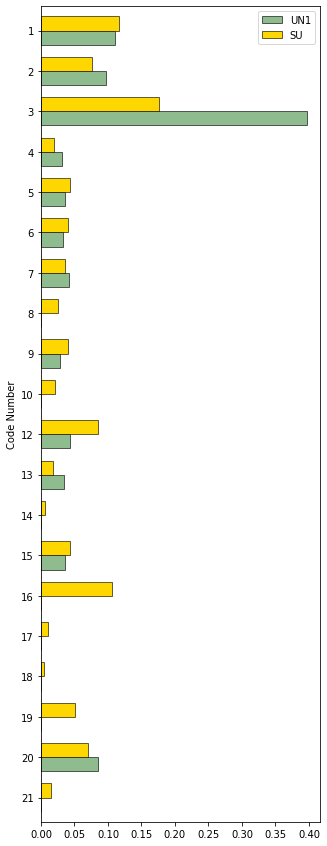

In [112]:
generate_topicdist_chart(merged_df)

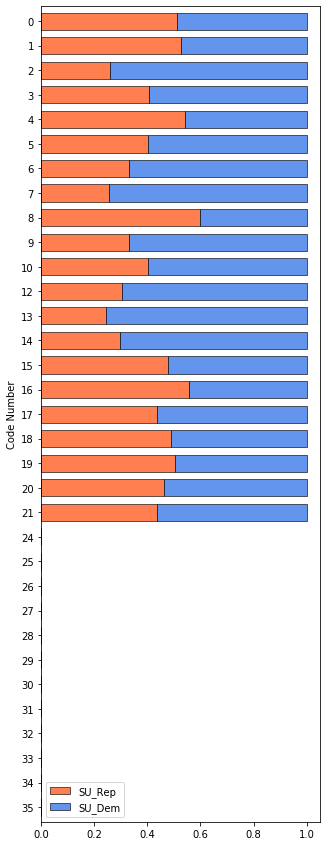

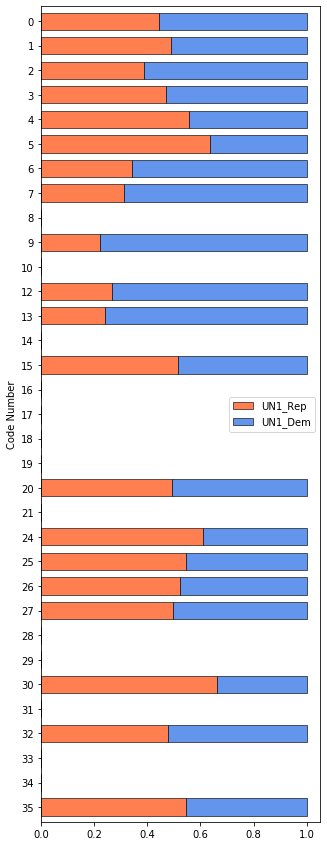

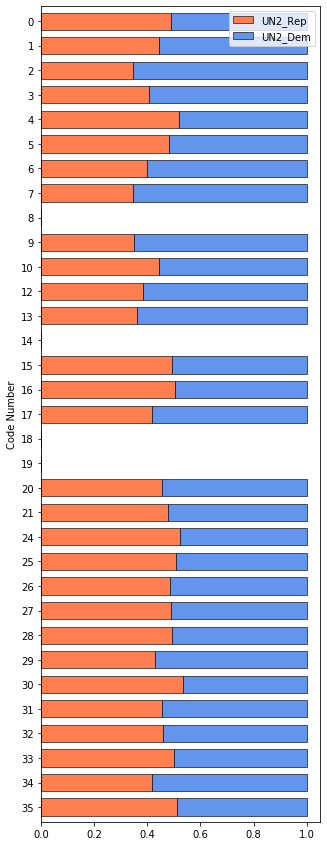

In [114]:
generate_party_charts(tweets_unsup_labeled, '../../../reports/figures/party_topicdistplot_sup_unsup_SU.png',
                     '../../../reports/figures/party_topicdistplot_sup_unsup_UN1.png',
                     '../../../reports/figures/party_topicdistplot_sup_unsup_UN2.png')

## Evaluating Agreement Between Supervised and Unsupervised Labels by Topic

In [119]:
def eval_agreement(df):
    tweets_analysis = df.copy()
    tweets_analysis['max_topic'] = tweets_analysis.max_topic.astype('int')
    tweets_analysis['max_topic_2'] = tweets_analysis.max_topic_2.astype('int')
    tweets_analysis['policy_area_lr'] = tweets_analysis.policy_area_lr.astype('int')
    
    ## for maximum probability topic
    print("% agreement of max probability topic with supervised model label:")
    max_d = {}
    for each in range(24):
        new_df = tweets_analysis.loc[tweets_analysis['max_topic'] == each]

        ## try finding proportional agreement
        new_df_matches = new_df.loc[new_df['policy_area_lr'] == each]
        unsup_prop_matches = (new_df_matches.shape[0]  / (new_df.shape[0]-1))
        max_d[each] = unsup_prop_matches
        print("Topic "+str(each)+": "+str(unsup_prop_matches*100)+"%")
        
    print('-----')
    
    ## for second highest probability topic
    print("% agreement of 2nd max probability topic with supervised model label:")
    max2_d = {}
    for each in range(24):
        new_df = tweets_analysis.loc[tweets_analysis['max_topic_2'] == each]

        ## try finding proportional agreement
        new_df_matches = new_df.loc[new_df['policy_area_lr'] == each]
        unsup_prop_matches = (new_df_matches.shape[0]  / (new_df.shape[0]-1))
        max2_d[each] = unsup_prop_matches
        print("Topic "+str(each)+": "+str(unsup_prop_matches*100)+"%")
        
    return max_d, max2_d

In [120]:
max_d, max2_d = eval_agreement(tweets_unsup_labeled)

% agreement of max probability topic with supervised model label:
Topic 0: 67.3896985965734%
Topic 1: 36.342110074968005%
Topic 2: 16.192690505407132%
Topic 3: 17.102749362642943%
Topic 4: 19.781123708021887%
Topic 5: 8.723638245568639%
Topic 6: 45.6794425087108%
Topic 7: 18.455849056603775%
Topic 8: -0.0%
Topic 9: 43.00620636152056%
Topic 10: -0.0%
Topic 11: -0.0%
Topic 12: 55.976415466821095%
Topic 13: 18.32286786936443%
Topic 14: -0.0%
Topic 15: 28.493311774217254%
Topic 16: -0.0%
Topic 17: -0.0%
Topic 18: -0.0%
Topic 19: -0.0%
Topic 20: 12.127465744510756%
Topic 21: -0.0%
Topic 22: -0.0%
Topic 23: -0.0%
-----
% agreement of 2nd max probability topic with supervised model label:
Topic 0: 53.49443030067859%
Topic 1: 19.740388142052975%
Topic 2: 11.59748721110426%
Topic 3: 33.28310445535326%
Topic 4: 10.193518302634647%
Topic 5: 4.538121922227883%
Topic 6: 19.564761625225376%
Topic 7: 19.079853143643874%
Topic 8: -0.0%
Topic 9: 20.665203444200575%
Topic 10: 7.050457162207923%
Topic 11

## Individual Topic Case Studies

We can see from our tables that our supervised model detects topics 12 (law and crime), 6 (education), and 9 (immigration) for approximately one half of all cases that our supervised model detects these topics. These three topics represent the those topics with the highest proportion of matches. Those topics the represent the lowest proportion of matches from supervised to unsupervised include topics 5 (labor), 15 (domestic commerce), and 2 (civil rights). Let's look to a couple of case studies to understand where these discrepancies might come from.

In [121]:
def topic_case_study(df, topic_number):
    
    ## prepare data as needed
    tweets_analysis = df.copy()
    tweets_analysis['max_topic'] = tweets_analysis.max_topic.astype('int')
    tweets_analysis['max_topic_2'] = tweets_analysis.max_topic_2.astype('int')
    tweets_analysis['policy_area_lr'] = tweets_analysis.policy_area_lr.astype('int')
    
    ## find matches between unsupervised and supervised (max probablity) topic labels 
    unsup_topic = tweets_analysis[tweets_analysis['policy_area_lr'] == topic_number]
    matched_topics = unsup_topic[unsup_topic['max_topic'] == topic_number] 
    topic_df = matched_topics[['policy_area_lr','max_topic','full_text']]
    
    ## output to csv if desired
    # topic_df.to_csv('../../../reports/tables/topiccasestudy_'+str(topic_number)+'.csv.gz',
                   # compression='gzip', index=False)
    
    return topic_df

In [122]:
topic_df = topic_case_study(tweets_unsup_labeled, 3)
topic_df.head()

,policy_area_lr,max_topic,full_text
32,3,3,@ATT and @DIRECTV are showing how little they ...
73,3,3,"Today's read: Kasich, Hickenlooper release pla..."
77,3,3,We also can't forget about the crews at the @U...
204,3,3,@NOAADebris This grant will be used to reduce ...
290,3,3,Thank you @BlueCrossMN! Enjoyed discussion on ...
